In [1]:
pip install opencv-python pillow numpy scikit-learn tensorflow torch torchvision

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/ec/6c/fab8113424af5049f85717e8e527ca3773299a3c6b02506e66436e19874f/opencv_python-4.10.0.84-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/e4/14/d795bb156f8cc10eb1dcfe1332b7dbb8405b634688980aa9be8f885cc888/tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d3/1d/a257913c89572de61316461db91867f87519146e58132cdeace3d9ffbe1f/torch-2.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/c3/a21a75dd2de8114a6876f16a36b033e3e62f8ade68085a711b24f4b57c17/torchvision-0.18.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.16.1 from https://files.pythonhosted.org/packages/e0/36/6278e4e7e69a90c00e0f82944d8


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt 

In [4]:
def load_images(directory, size=(128, 128)):
    img_list = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        image = cv2.imread(path)
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, size)
            image = image / 255.0
            img_list.append(image)
    return img_list

In [5]:
low_quality_path = 'C:/Users/VEDANT VERMA/Desktop/Train/low'
high_quality_path = 'C:/Users/VEDANT VERMA/Desktop/Train/high'
image_size = (128, 128)

In [6]:
# Load the Images
low_quality_images = load_images(low_quality_path, image_size)
high_quality_images = load_images(high_quality_path, image_size)

In [7]:
train_low, test_low, train_high, test_high = train_test_split(
    low_quality_images, high_quality_images, test_size=0.2, random_state=42
)

In [8]:
# Preprocessing Function for TensorFlow
def image_preprocessing(image):
    return tf.image.convert_image_dtype(image, tf.float32)

# Create TensorFlow Datasets
train_low_ds = tf.data.Dataset.from_tensor_slices(train_low).map(image_preprocessing).batch(32)
train_high_ds = tf.data.Dataset.from_tensor_slices(train_high).map(image_preprocessing).batch(32)
test_low_ds = tf.data.Dataset.from_tensor_slices(test_low).map(image_preprocessing).batch(32)
test_high_ds = tf.data.Dataset.from_tensor_slices(test_high).map(image_preprocessing).batch(32)

In [9]:
# Combine Noisy and Clean Images for Training
training_dataset = tf.data.Dataset.zip((train_low_ds, train_high_ds))
testing_dataset = tf.data.Dataset.zip((test_low_ds, test_high_ds))


In [10]:
# Model Creation Function
def build_denoising_network(input_shape):
    net = models.Sequential()
    net.add(layers.Input(shape=input_shape))
    net.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    net.add(layers.MaxPooling2D((2, 2), padding='same'))
    net.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    net.add(layers.MaxPooling2D((2, 2), padding='same'))
    net.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    net.add(layers.UpSampling2D((2, 2)))
    net.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    net.add(layers.UpSampling2D((2, 2)))
    net.add(layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    return net
# Define the Model
input_dimensions = (128, 128, 3)
denoising_model = build_denoising_network(input_dimensions)
denoising_model.compile(optimizer='adam', loss='mean_squared_error')
denoising_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,731 (194.26 KB)

 Trainable params: 49,731 (194.26 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the Model
training_history = denoising_model.fit(training_dataset, epochs=50, validation_data=testing_dataset)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - loss: 0.0472 - val_loss: 0.0386
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 410ms/step - loss: 0.0362 - val_loss: 0.0323
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - loss: 0.0326 - val_loss: 0.0299
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 435ms/step - loss: 0.0305 - val_loss: 0.0297
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 432ms/step - loss: 0.0308 - val_loss: 0.0285
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - loss: 0.0284 - val_loss: 0.0276
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - loss: 0.0281 - val_loss: 0.0269
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - loss: 0.0275 - val_loss: 0.0263
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 426ms/step - loss: 0.0266 - val_loss: 0.0261
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 429ms/step - loss: 0.0269 - val_loss: 0.0262
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - loss: 0.0259 - val_loss: 0.0258
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step

In [12]:
# Predict with the Model
output_images = denoising_model.predict(test_low_ds)

# Calculate PSNR
psnr_scores = [psnr(test_high[i], output_images[i]) for i in range(len(test_high))]
mean_psnr = np.mean(psnr_scores)
print(f'Average PSNR: {mean_psnr}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step
Average PSNR: 17.29026880820179


C:\Users\VEDANT VERMA\AppData\Local\Temp\ipykernel_1996\2639005953.py:5: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr_scores = [psnr(test_high[i], output_images[i]) for i in range(len(test_high))]


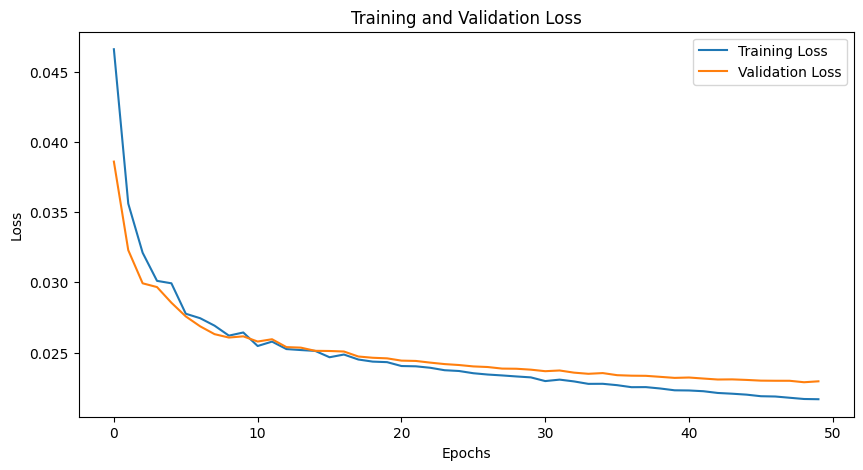

In [19]:
# Plot training and validation loss

plt.figure(figsize=(10, 5))
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

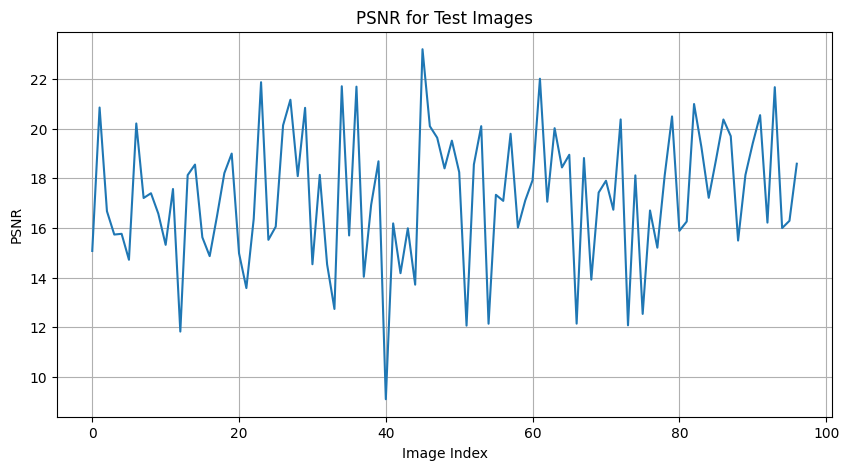

In [15]:
# Plot PSNR for each image
plt.figure(figsize=(10, 5))
plt.plot(psnr_scores)
plt.title('PSNR for Test Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR')
plt.grid()
plt.show()

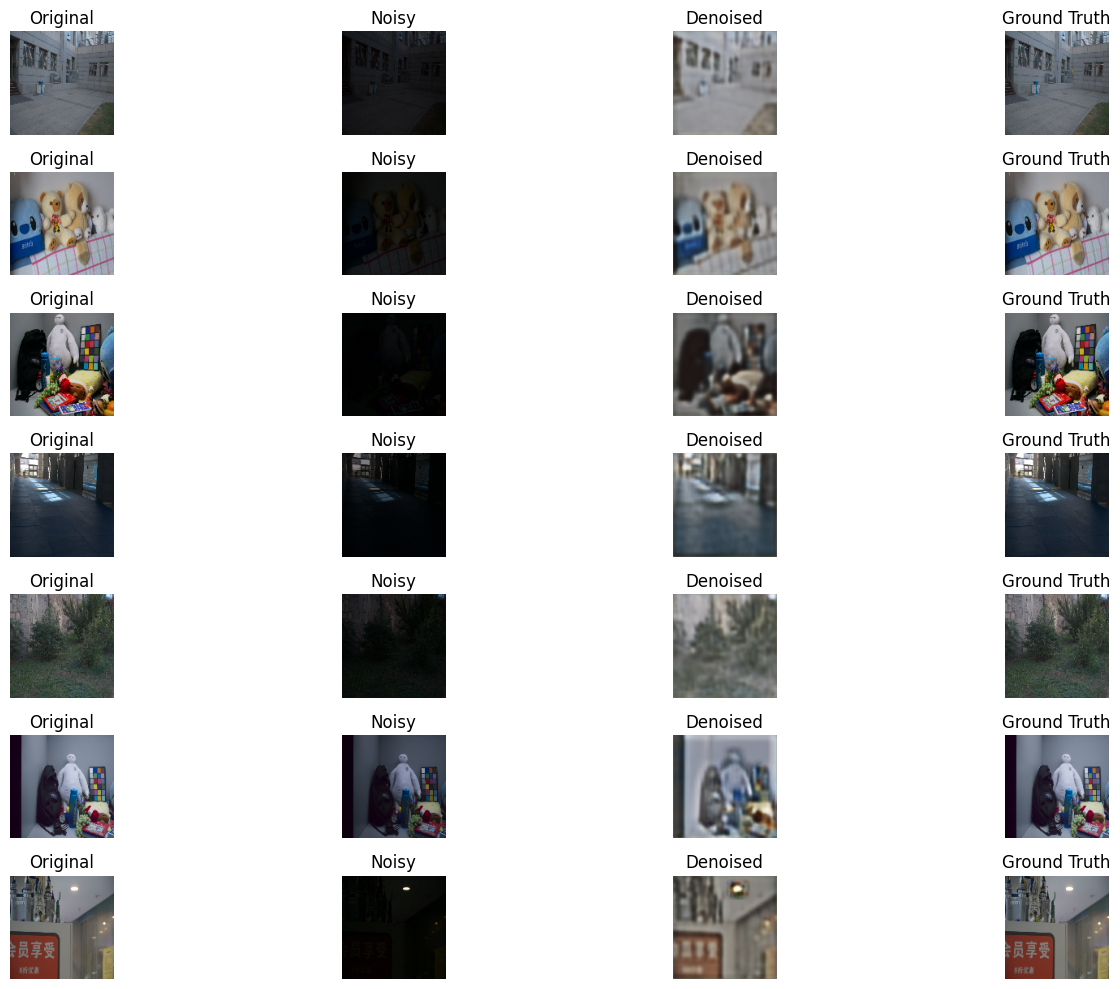

In [22]:
# Plot Sample Image Comparison
num_samples = 7
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(num_samples, 4, i*4+1)
    plt.imshow(test_high[i])
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(num_samples, 4, i*4+2)
    plt.imshow(test_low[i])
    plt.title('Noisy')
    plt.axis('off')
    
    plt.subplot(num_samples, 4, i*4+3)
    plt.imshow(output_images[i])
    plt.title('Denoised')
    plt.axis('off')
    
    plt.subplot(num_samples, 4, i*4+4)
    plt.imshow(test_high[i])
    plt.title('Ground Truth')
    plt.axis('off')

plt.tight_layout()
plt.show()